In [4]:
from sklearnex import patch_sklearn

patch_sklearn()

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC, ConfusionMatrix
from sklearn.metrics import classification_report

import pickle
import json
from copy import deepcopy
from sklearn.model_selection import train_test_split
from drowsiness_detection.data import (get_feature_data, preprocess_feature_data,
                                       session_type_mapping, load_experiment_objects, load_preprocessed_train_test_splits)
from drowsiness_detection.visualize import plot_roc_curve_from_log_dir, plot_learning_curve_from_log_dir
from drowsiness_detection import config
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = 14, 7

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
# fixed experiment params
EXPERIMENT_IDS = (21, 23, 25)

m## Plot ROC Curve of best model for 10, 20 and 60 seconds data

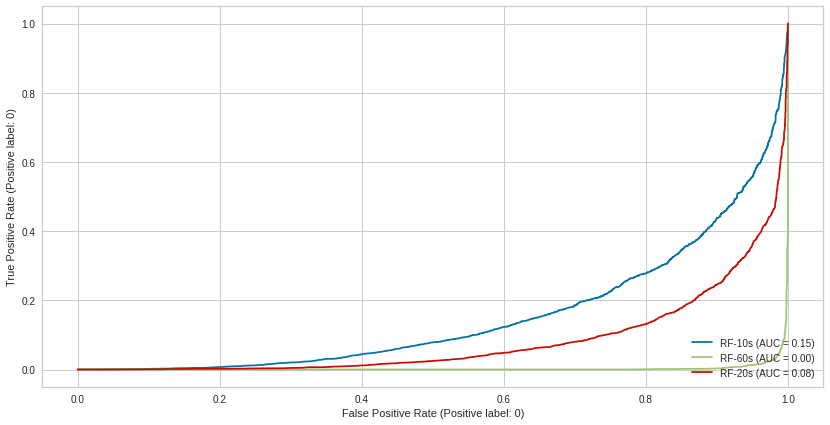

In [9]:
fig, ax = plt.subplots()

for experiment_id in EXPERIMENT_IDS:
    plot_roc_curve_from_log_dir(experiment_id=experiment_id, ax=ax, pos_label=0)

### Plot learning curve of best model for 10, 20 and 60 seconds data


KeyboardInterrupt: 

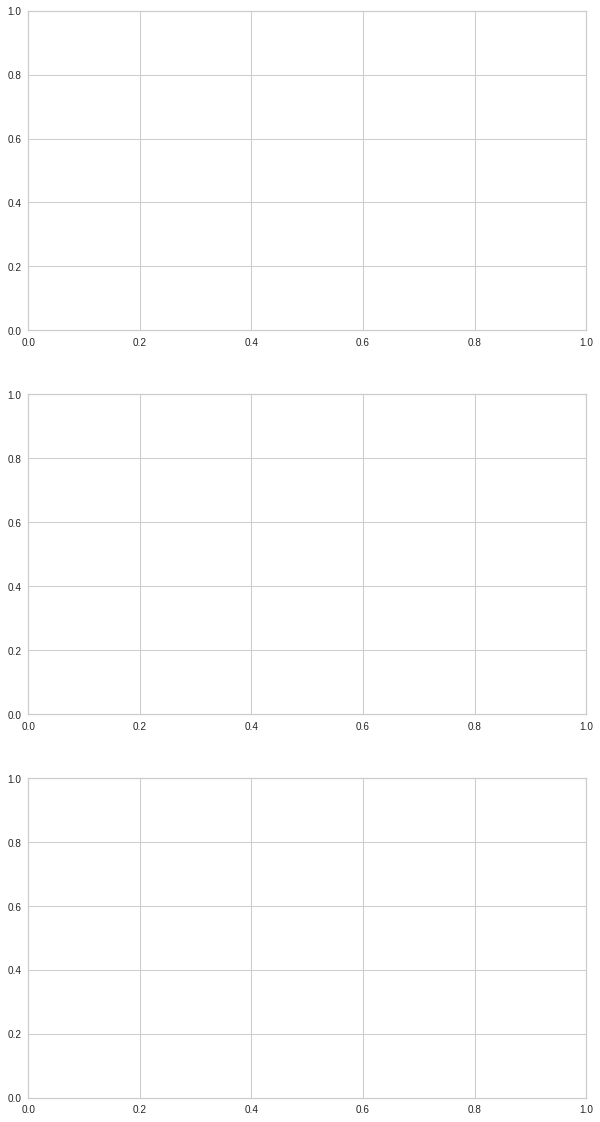

In [54]:
plt.rcParams["figure.figsize"] = 10, 20

n_estimator_options = np.logspace(2, 9, num=10, base=2)
_, axes = plt.subplots(len(EXPERIMENT_IDS), 1)
for experiment_id, ax in zip(EXPERIMENT_IDS, axes):
    plot_learning_curve_from_log_dir(experiment_id=experiment_id,
                                     n_estimator_options=n_estimator_options, ax=ax)


### Plot classification report of best model for 10, 20 and 60 seconds data


In [12]:
label_names_dict = { # num_targets: label_names
    2: ["not drowsy", "drowsy"],
    3: ["active", "neutral", "drowsy"],
    5: ["alert", "awake", "neutral", "slightly drowsy", "drowsy"]
}

In [ ]:
for experiment_id in EXPERIMENT_IDS:
    exp_config, best_estimator, _ = load_experiment_objects(experiment_id=experiment_id)

    window_size = exp_config["window_in_sec"]
    config.set_paths(30, window_size)

    # load data
    X_train, X_test, y_train, y_test = load_preprocessed_train_test_splits(
        data_path=config.PATHS.WINDOW_FEATURES,
        exclude_sess_type=session_type_mapping[exp_config["exclude_by"]],
        num_targets=exp_config["num_targets"],
        seed=exp_config["seed"],
        test_size=exp_config["test_size"])

    y_hat = best_estimator.predict(X_test)
    report = classification_report(y_true=y_test, y_pred=y_hat, target_names=label_names_dict[exp_config["num_targets"]])
    print(report)

### Plot Classification Report/ROC Curve/Confusion Matrix of 60 sec. Random Forest but for KSS scored discretized in 2, 3 and 5 target variables.
* micro-average: weight the metric score of each class by the size of predictions belonging to that class
* macro-average: calculate metric score for each class and then weight uniformly

Mirco-average is preferable for imbalanced data like it is here, but the drowsy class is underrepresented yet more important. Hence macro-average can also be used.

Showing analysis of result for experiment 26 with 2 targets.
              precision    recall  f1-score   support

  not drowsy       0.96      0.99      0.97      3837
      drowsy       0.99      0.94      0.96      2591

    accuracy                           0.97      6428
   macro avg       0.97      0.96      0.97      6428
weighted avg       0.97      0.97      0.97      6428



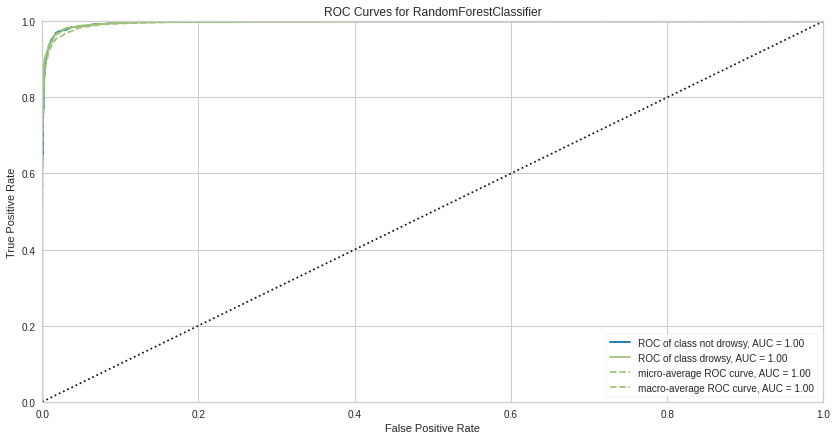

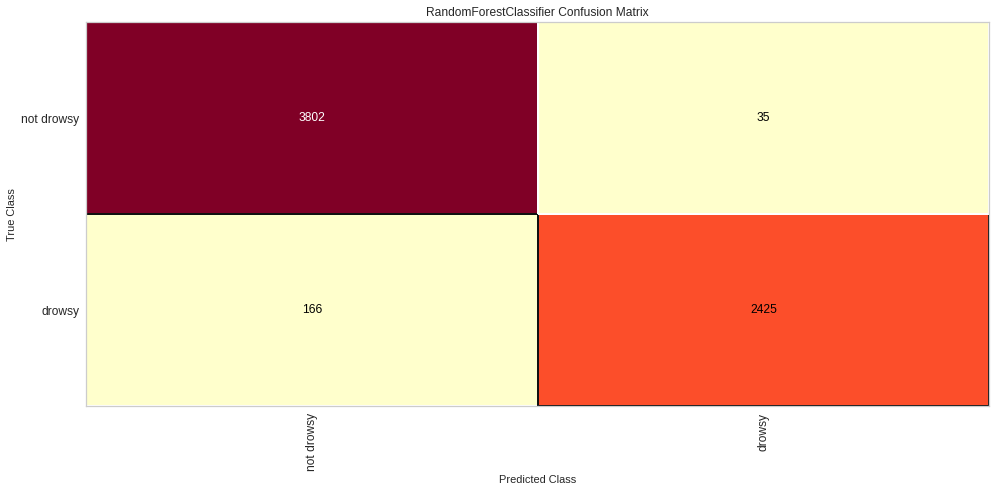

Showing analysis of result for experiment 27 with 3 targets.
              precision    recall  f1-score   support

      active       0.93      0.99      0.96      3400
     neutral       0.98      0.90      0.94      1735
      drowsy       0.99      0.91      0.95      1293

    accuracy                           0.95      6428
   macro avg       0.97      0.94      0.95      6428
weighted avg       0.95      0.95      0.95      6428



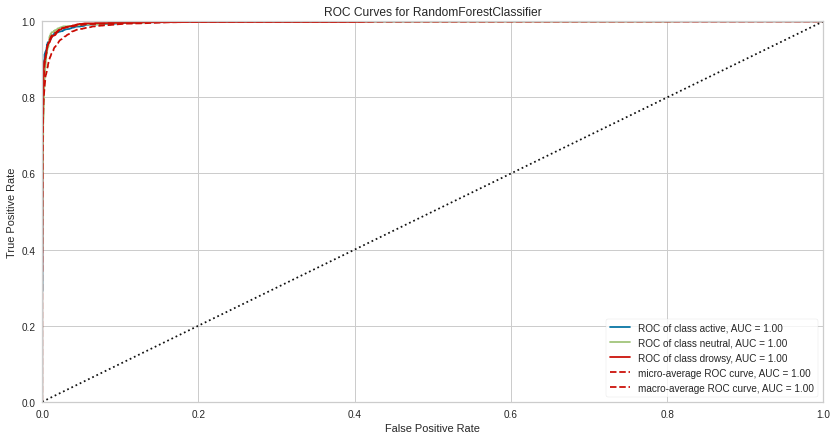

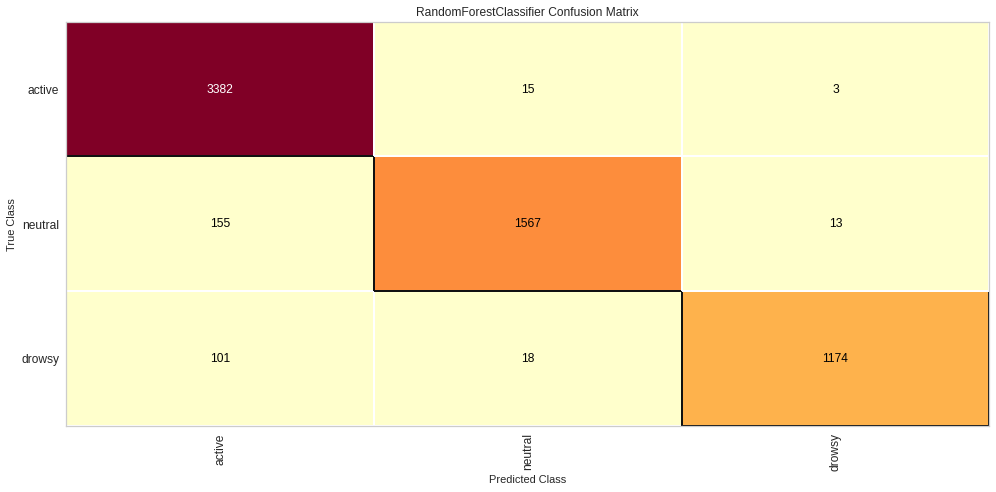

Showing analysis of result for experiment 28 with 5 targets.
                 precision    recall  f1-score   support

          alert       0.98      0.94      0.96      1161
          awake       0.95      0.97      0.96      1667
        neutral       0.98      0.91      0.95      1009
slightly drowsy       0.94      0.99      0.96      2195
         drowsy       0.99      0.84      0.91       396

       accuracy                           0.96      6428
      macro avg       0.97      0.93      0.95      6428
   weighted avg       0.96      0.96      0.96      6428



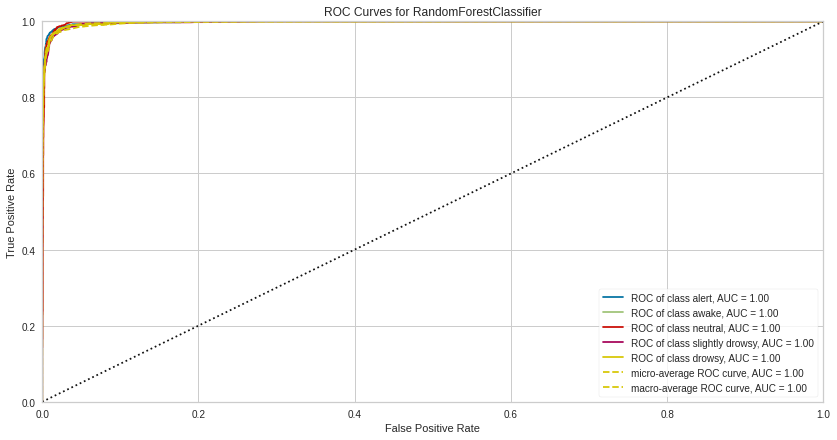

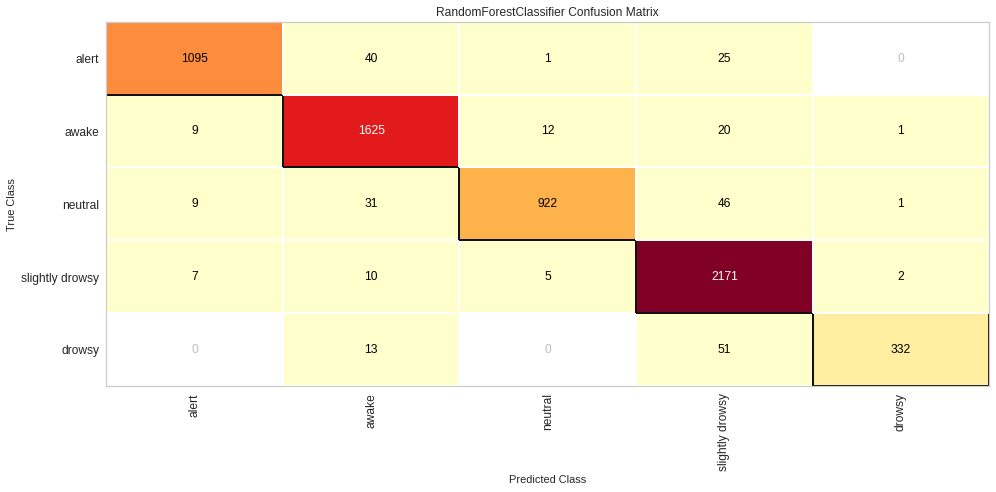

In [18]:
MULTI_TARGET_EXPERIMENT_IDS = 26,27,28
for experiment_id in MULTI_TARGET_EXPERIMENT_IDS:
    exp_config, best_estimator, _ = load_experiment_objects(experiment_id=experiment_id)
    print(f"Showing analysis of result for experiment {experiment_id} with {exp_config['num_targets']} targets.")

    window_size = exp_config["window_in_sec"]
    config.set_paths(30, window_size)

    # load data
    X_train, X_test, y_train, y_test = load_preprocessed_train_test_splits(
        data_path=config.PATHS.WINDOW_FEATURES,
        exclude_sess_type=session_type_mapping[exp_config["exclude_by"]],
        num_targets=exp_config["num_targets"],
        seed=exp_config["seed"],
        test_size=exp_config["test_size"])

    # CLASSIFICATION REPORT
    y_hat = best_estimator.predict(X_test)
    report = classification_report(y_true=y_test, y_pred=y_hat, target_names=label_names_dict[exp_config["num_targets"]], )
    print(report)

    # ROC CURVE
    visualizer = ROCAUC(best_estimator, classes=label_names_dict[exp_config["num_targets"]], is_fitted=True)
    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()

    # CONFUSION MATRIX
    visualizer = ConfusionMatrix(best_estimator, classes=label_names_dict[exp_config["num_targets"]], is_fitted=True)

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()
